In [1]:
import os
import sys
sys.path.insert(0,'../../../')
import glob
import chess.pgn
import shutil
import logging
import io
import numpy as np
from pathlib import Path
from DeepCrazyhouse.configs.main_config import main_config
from DeepCrazyhouse.src.preprocessing.game_phase_detector import get_game_phase
from tqdm import tqdm
from copy import deepcopy
import multiprocessing as mp
import json
import matplotlib.pyplot as plt

# Loads and analyses a file created by the analyse_game_phases.py script

In [11]:
with open("analyse_game_phase_data_testset.json", 'r') as f:
    results, all_outcomes_flattened, all_elos_flattened = json.load(f)

In [12]:
all_moves_all_games, all_y_values_all_games, num_moves_all_games, phase_move_counter_all_games, phase_y_values_all_games, phase_moves_all_games = zip(*results)

In [13]:
len(phase_y_values_all_games)

1000

In [14]:
len(all_outcomes_flattened)

1000

In [15]:
phase_move_counter_all_games[0]

{'0': 31, '1': 37, '2': 72}

In [16]:
# per position
total_positions_phase0 = 0
total_positions_phase1 = 0
total_positions_phase2 = 0
game_outcomes_all_positions_by_phase = {"0": {-1: 0, 0: 0, 1: 0}, "1": {-1: 0, 0: 0, 1: 0}, "2": {-1: 0, 0: 0, 1: 0}}

# per game
total_games = len(phase_move_counter_all_games)
games_considered_phase0 = 0
games_considered_phase1 = 0
games_considered_phase2 = 0
game_outcomes_by_phase = {"0": {-1: 0, 0: 0, 1: 0}, "1": {-1: 0, 0: 0, 1: 0}, "2": {-1: 0, 0: 0, 1: 0}}

for idx, game_phase_move_counter in enumerate(phase_move_counter_all_games):

    game_outcome = all_outcomes_flattened[idx]
    num_opening_moves = game_phase_move_counter["0"]
    num_midgame_moves = game_phase_move_counter["1"]
    num_endgame_moves = game_phase_move_counter["2"]
    
    total_positions_phase0 += num_opening_moves
    total_positions_phase1 += num_midgame_moves
    total_positions_phase2 += num_endgame_moves
    game_outcomes_all_positions_by_phase["0"][game_outcome] += num_opening_moves
    game_outcomes_all_positions_by_phase["1"][game_outcome] += num_midgame_moves
    game_outcomes_all_positions_by_phase["2"][game_outcome] += num_endgame_moves

    if num_opening_moves > 0:
        games_considered_phase0 += 1
        game_outcomes_by_phase["0"][game_outcome] += 1

    if num_midgame_moves > 0:
        games_considered_phase1 += 1
        game_outcomes_by_phase["1"][game_outcome] += 1

    if num_endgame_moves > 0:
        games_considered_phase2 += 1
        game_outcomes_by_phase["2"][game_outcome] += 1


total_positions = total_positions_phase0 + total_positions_phase1 + total_positions_phase2

In [17]:
total_positions_phase0, total_positions_phase1, total_positions_phase2

(24938, 31364, 28812)

In [18]:
game_outcomes_all_positions_by_phase

{'0': {-1: 6298, 0: 10445, 1: 8195},
 '1': {-1: 9267, 0: 10880, 1: 11217},
 '2': {-1: 8051, 0: 12511, 1: 8250}}

In [19]:
total_games, games_considered_phase0, games_considered_phase1, games_considered_phase2

(1000, 1000, 971, 717)

In [ ]:
print(games_considered_phase0/total_games, games_considered_phase1/total_games, games_considered_phase2/total_games)
plt.bar(list(range(3)), [games_considered_phase0, games_considered_phase1, games_considered_phase2], align="center")
plt.title("total games by phase")
plt.xticks(list(range(3)), ["opening", "midgame", "endgame"])

1.0 0.971 0.717


([<matplotlib.axis.XTick at 0x28be3920c70>,
 [Text(0, 0, 'opening'), Text(1, 0, 'midgame'), Text(2, 0, 'endgame')])

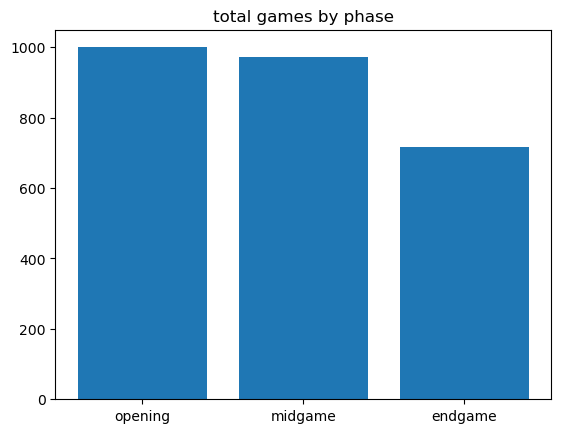

In [12]:
# total games by phase
print(games_considered_phase0/total_games, games_considered_phase1/total_games, games_considered_phase2/total_games)
plt.bar(list(range(3)), [games_considered_phase0, games_considered_phase1, games_considered_phase2], align="center")
plt.title("total games by phase")
plt.xticks(list(range(3)), ["opening", "midgame", "endgame"])

([<matplotlib.axis.XTick at 0x28be2b5d7f0>,
 [Text(0, 0, 'opening'), Text(1, 0, 'midgame'), Text(2, 0, 'endgame')])

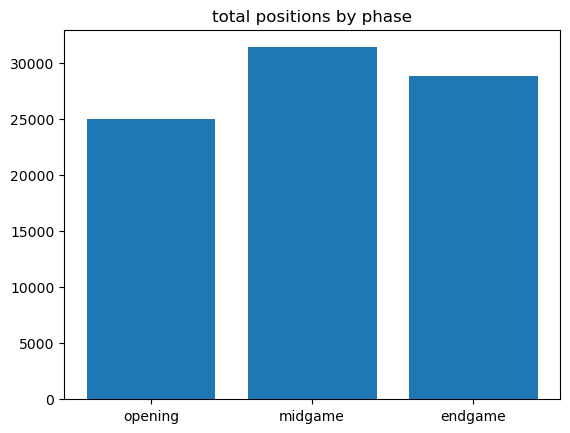

In [13]:
# total positions by phase
plt.bar(list(range(3)), [total_positions_phase0, total_positions_phase1, total_positions_phase2], align="center")
plt.title("total positions by phase")
plt.xticks(list(range(3)), ["opening", "midgame", "endgame"])

In [14]:
num_draws_total = all_outcomes_flattened.count(0)
num_white_wins_total = all_outcomes_flattened.count(1)
num_black_wins_total = all_outcomes_flattened.count(-1)
print(num_draws_total, num_white_wins_total, num_black_wins_total)

424 325 251


[0.325, 0.424, 0.251]


([<matplotlib.axis.XTick at 0x28be2a49c10>,
 [Text(0, 0, 'white_win'), Text(1, 0, 'draw'), Text(2, 0, 'black_win')])

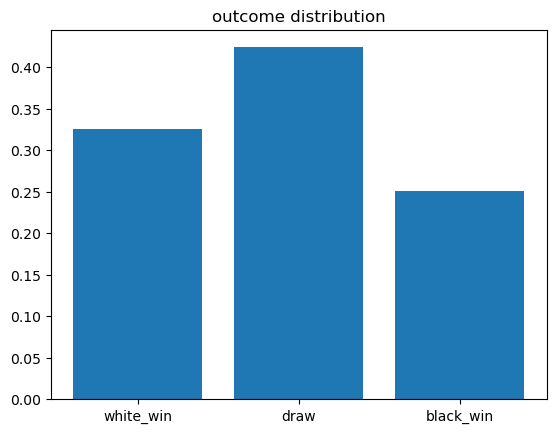

In [15]:
# outcome distribution
outcomes_distribution_phase0 = [game_outcomes_by_phase["0"][1]/total_games, game_outcomes_by_phase["0"][0]/total_games, game_outcomes_by_phase["0"][-1]/total_games]
print(outcomes_distribution_phase0)
plt.bar(list(range(3)), outcomes_distribution_phase0, align="center")
plt.title("outcome distribution")
plt.xticks(list(range(3)), ["white_win", "draw", "black_win"])

[0.33470648815653964, 0.40679711637487126, 0.2584963954685891]


([<matplotlib.axis.XTick at 0x28be2ac10d0>,
 [Text(0, 0, 'white_win'), Text(1, 0, 'draw'), Text(2, 0, 'black_win')])

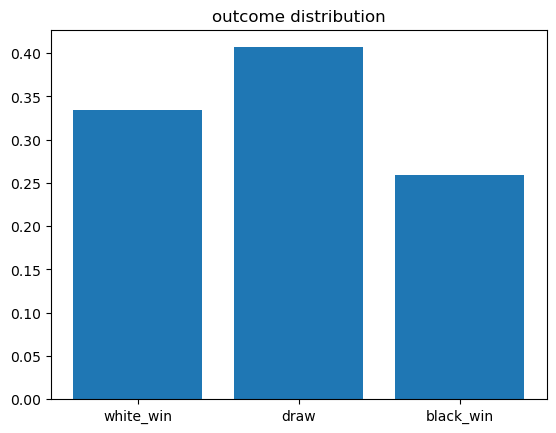

In [16]:
# outcome distribution
outcomes_distribution_phase0 = [game_outcomes_by_phase["1"][1]/games_considered_phase1, game_outcomes_by_phase["1"][0]/games_considered_phase1, game_outcomes_by_phase["1"][-1]/games_considered_phase1]
print(outcomes_distribution_phase0)
plt.bar(list(range(3)), outcomes_distribution_phase0, align="center")
plt.title("outcome distribution")
plt.xticks(list(range(3)), ["white_win", "draw", "black_win"])

[0.33472803347280333, 0.3891213389121339, 0.27615062761506276]


([<matplotlib.axis.XTick at 0x28be2b1d4f0>,
 [Text(0, 0, 'white_win'), Text(1, 0, 'draw'), Text(2, 0, 'black_win')])

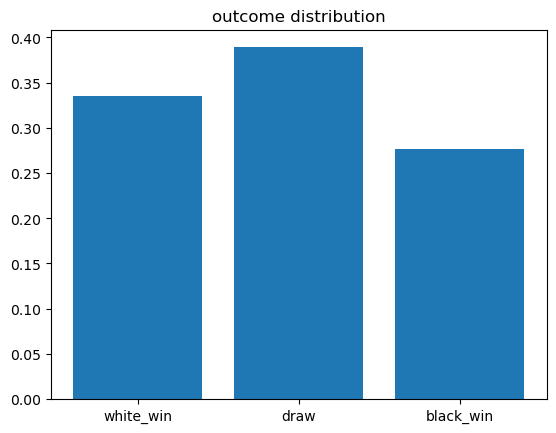

In [17]:
# outcome distribution
outcomes_distribution_phase0 = [game_outcomes_by_phase["2"][1]/games_considered_phase2, game_outcomes_by_phase["2"][0]/games_considered_phase2, game_outcomes_by_phase["2"][-1]/games_considered_phase2]
print(outcomes_distribution_phase0)
plt.bar(list(range(3)), outcomes_distribution_phase0, align="center")
plt.title("outcome distribution")
plt.xticks(list(range(3)), ["white_win", "draw", "black_win"])